In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility import *
from tools import *
from maps import *
from scipy.stats import linregress
from sklearn.cluster import KMeans
from scipy.ndimage import label, find_objects
from scipy.spatial.distance import pdist, squareform

In [ ]:
# Load the Data's directory.
datadir = 'C:/Users/txu245/Desktop/26-02-17/Add/02_01_05.zda'

# Load the Tool Packages.
DataLoader = DataLoader(datadir)
Tools = Tools()
Maps = Maps()

In [45]:
# Parameters setting up.
index = np.linspace(0, 499.5, 1000)
basePt = 190
skipPt = 60
startPt = 190
numPt = 60

# Data Preprocessing.
Data = DataLoader.get_data()
Data = Tools.Polynomial(startPt=basePt, numPt=skipPt, Data=Data)
Rli = DataLoader.get_rli()
Data = Tools.Rli_Division(Rli=Rli, Data=Data)
Data = Tools.T_filter(Data=Data)
Data = Tools.S_filter(sigma=1, Data=Data)
Data_ave = np.mean(Data, axis=0)

# SNR Map. (Without Normalization)
map = np.zeros((80, 80))
sd = np.zeros((80, 80))

for i in range(80):
    for j in range(80):
        SD = np.std(Data_ave[i, j, 10:60], ddof=1)
        MaxAmp = np.max(Data_ave[i, j, startPt:(startPt+numPt)])
        SNR = MaxAmp / SD
        map[i][j] = SNR
        sd[i][j] = SD

In [46]:
# Step 1: Discard SNR < RMS Pixels.
mask = (map >= sd)
filtered_pixels = map[mask].reshape(-1, 1)

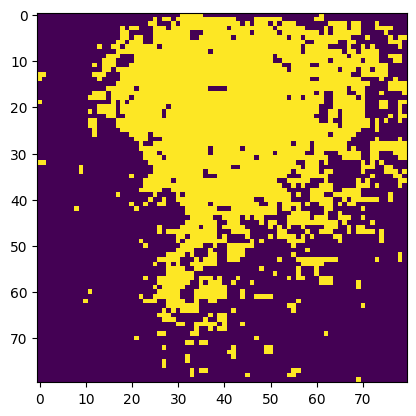

In [47]:
# Step 2: K-Means Clustering.
kmeans = KMeans(n_clusters=2, random_state=0, n_init=70)
labels = kmeans.fit_predict(filtered_pixels)
centers = kmeans.cluster_centers_.flatten()
low_cluster = centers.argmin()
labels = (labels != low_cluster).astype(int)

clustered_map = np.zeros_like(map, dtype=int)
clustered_map[mask] = labels

plt.imshow(clustered_map)
plt.show()

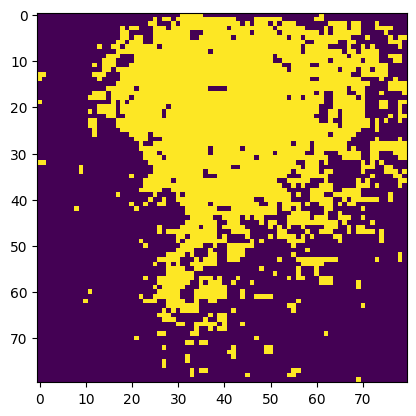

In [48]:
# Step 3: Discard those groups with an average SNR < 6.
valid_clustered_map = np.zeros_like(clustered_map)

labeled_groups, num_groups = label(clustered_map)

for group_id in range(1, num_groups + 1):

    AVE_SNR = np.mean(map[np.where(labeled_groups == group_id)])

    if AVE_SNR >= 6:
        valid_clustered_map[np.where(labeled_groups == group_id)] = 1

plt.imshow(valid_clustered_map)
plt.show()

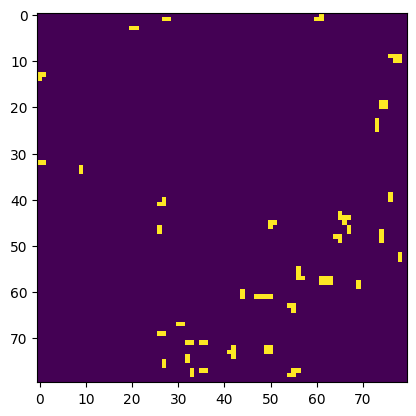

In [49]:
# Step 4: Shape Limitation.
labeled_groups, num_groups = label(valid_clustered_map)

final_map = np.zeros_like(valid_clustered_map)

for group_id in range(1, num_groups + 1):

    coords = np.column_stack(np.where(labeled_groups == group_id))
    n_pixels = len(coords)

    # 4. Discard groups with >9 pixels
    if n_pixels > 9:
        continue

    # 7. Discard groups with only 1 pixel
    if n_pixels == 1:
        continue

    # 6. Discard groups more than 3 pixels across
    # (max pairwise distance)
    if n_pixels > 1:
        max_dist = np.max(pdist(coords))
        if max_dist > 3:
            continue

    # Keep valid group
    final_map[labeled_groups == group_id] = 1

plt.imshow(final_map)
plt.show()

In [50]:
# Step 5: Latency Correlation.

labeled_groups, num_groups = label(final_map)
latency = np.zeros((num_groups, Data.shape[0]))

for trial in range(Data.shape[0]):

    sub_data = Data[trial]

    for group_id in range(1, num_groups + 1):

        mean_trace = np.mean(sub_data[np.where(labeled_groups == group_id)], axis=0)
        mean_latency = Maps.Half_Amp_Latency(mean_trace, startPt=startPt, numPt=numPt)
        latency[group_id-1][trial] = mean_latency

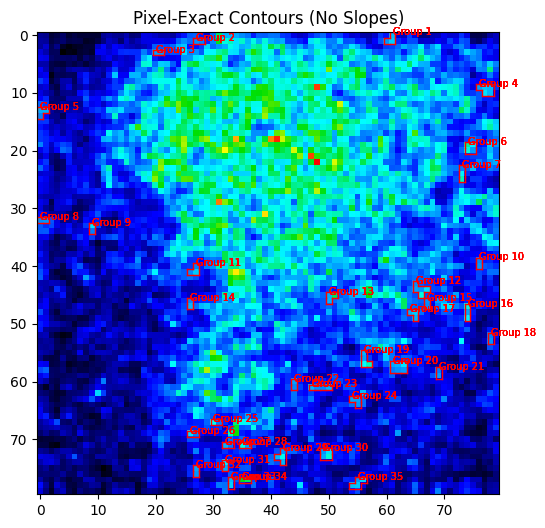

In [51]:
# Final Result.
def draw_pixel_exact_contours(mask, ax, linewidth=1, color='red'):
    labeled, num_groups = label(mask)

    for group_id in range(1, num_groups + 1):
        group = (labeled == group_id)

        rows, cols = np.where(group)

        edges = []

        for r, c in zip(rows, cols):

            # Check 4 directions
            neighbors = [
                (r-1, c),  # top
                (r+1, c),  # bottom
                (r, c-1),  # left
                (r, c+1)   # right
            ]

            # Pixel boundaries
            top_edge    = [(c-0.5, r-0.5), (c+0.5, r-0.5)]
            bottom_edge = [(c-0.5, r+0.5), (c+0.5, r+0.5)]
            left_edge   = [(c-0.5, r-0.5), (c-0.5, r+0.5)]
            right_edge  = [(c+0.5, r-0.5), (c+0.5, r+0.5)]

            directions = [
                (neighbors[0], top_edge),
                (neighbors[1], bottom_edge),
                (neighbors[2], left_edge),
                (neighbors[3], right_edge)
            ]

            for (nr, nc), edge in directions:
                if not (0 <= nr < mask.shape[0] and 0 <= nc < mask.shape[1]) \
                   or not mask[nr, nc]:
                    edges.append(edge)

        # Draw edges
        for edge in edges:
            x = [edge[0][0], edge[1][0]]
            y = [edge[0][1], edge[1][1]]
            ax.plot(x, y, color=color, linewidth=linewidth)
            ax.annotate(text='Group {}'.format(group_id), xy=(cols[0], rows[0]), size=7, color='red')

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(map / np.max(map), cmap=Maps.colorbar())

draw_pixel_exact_contours(final_map, ax)

ax.set_xlim(-0.5, map.shape[1]-0.5)
ax.set_ylim(map.shape[0]-0.5, -0.5)
plt.title("Pixel-Exact Contours (No Slopes)")
plt.show()

In [52]:
count = 0
total = int((latency.shape[0] * (latency.shape[0]-1)) / 2)

for i in range(latency.shape[0]):
    for j in range(i+1, latency.shape[0]):

        Slope, _, _, PValue, _ = linregress(latency[i], latency[j])

        if PValue <= 0.05 and Slope > 0:
            count = count + 1
            print('Group', i+1, 'and Group', j+1, 'are correlated with a positive slope, and the P-Value is:', np.round(PValue, 6))

print(count, 'Pairs are correlated')
print('Totally', num_groups, 'groups and', total, 'pairs')
print('Correlation Percentage is:', count / total)

Group 2 and Group 5 are correlated with a positive slope, and the P-Value is: 0.004772
Group 2 and Group 32 are correlated with a positive slope, and the P-Value is: 0.023604
Group 5 and Group 32 are correlated with a positive slope, and the P-Value is: 0.002473
Group 6 and Group 7 are correlated with a positive slope, and the P-Value is: 0.046046
Group 6 and Group 25 are correlated with a positive slope, and the P-Value is: 0.021823
Group 7 and Group 27 are correlated with a positive slope, and the P-Value is: 0.044488
Group 8 and Group 21 are correlated with a positive slope, and the P-Value is: 0.031559
Group 13 and Group 24 are correlated with a positive slope, and the P-Value is: 0.04995
Group 15 and Group 30 are correlated with a positive slope, and the P-Value is: 0.046326
Group 16 and Group 19 are correlated with a positive slope, and the P-Value is: 0.01326
Group 16 and Group 30 are correlated with a positive slope, and the P-Value is: 0.010259
Group 18 and Group 23 are correl